In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from submm.KIDs.res import fitting as res_fit
from submm.sample_data.abs_paths import abs_path_sample_data
from importlib import reload
from submm.KIDs import calibrate

# Noise calibration example
## Load the Sample Data

In [5]:
data_path = os.path.join(abs_path_sample_data,
                         "Res1_2_Tbb3.500K_Tbath60.0mK_ATN1_22dB_ATN2_22dB_gain_sweep_2.p")
fileObj = open(data_path, 'rb')
sample_gain_data = pickle.load(fileObj) # a large sweep to measure cable delay
fileObj.close()

data_path = os.path.join(abs_path_sample_data,
                         "Res3_4.p")
fileObj = open(data_path, 'rb')
sample_data = pickle.load(fileObj) # a large sweep to measure cable delay
fileObj.close()


### First lets just have a look at the data
this data structure contains data and metadata for two resonator simulatanouly measured\\
we will just look at the first resonators

The sample data contains three dictionaries.

traj --(the calibration iq sweep)

noise --(1 second of noise data at 2.5 MHz data rate)

noised --(120 seconds of noise data at 10kHz data rate)


In [6]:
for key in sample_data.keys():
    print(key)
    for lower_key in sample_data[key].keys():
        print("    "+lower_key + " shape:" + str(sample_data[key][lower_key].shape))
        
f_iq_gain = sample_gain_data['traj']['farray'][:,0]
z_iq_gain = sample_gain_data['traj']['zarray'][:,0]
        
f_iq = sample_data['traj']['farray'][:,0]
z_iq = sample_data['traj']['zarray'][:,0]
f_stream = sample_data['noised']['fn'][0]
z_stream = sample_data['noised']['zn'][:,0]

traj
    tau shape:(2,)
    farray shape:(121, 2)
    zarray shape:(121, 2)
    dzdf shape:(121, 2)
    fnid shape:(2,)
noise
    fn shape:(2,)
    fs shape:(2,)
    adtime shape:(2,)
    nshot shape:(2,)
    r shape:(2,)
    ch shape:(4, 2)
    vin shape:(2, 2)
    tt shape:(2, 2, 2)
    zfn shape:(2,)
    zn shape:(250000, 2)
noised
    fn shape:(2,)
    fs shape:(2,)
    adtime shape:(2,)
    nshot shape:(2,)
    r shape:(2,)
    ch shape:(4, 2)
    vin shape:(2, 2)
    tt shape:(2, 2, 2)
    zfn shape:(2,)
    zn shape:(120000, 2)


### Plot the iq sweep

## Removing cable delay

When measuring a phase signal like we do in IQ space, you are always comparing the measured phase to some reference phase. Since when we measure a resonator, our signal passes through a non-zero length of coax, there will be a frequency-dependent phase delay between the phase we are measuring and the reference phase. For a homodyne readout this is phase difference between the RF signle and the LO signal you feed into the mixer.

This frequency-dependent phase delay needs to be removed because the calibration data is for various frequencies, but the streaming data is only for a single frequency.

We measure this by plotting phase versus frequency. Since the resonator also affects phase, an ideal measurement would be in a frequency region that does not have any resonators. The larger the measurement's frequency span, the easier it is to fit the frequency-dependent phase delay.

This effect is well constrained by a single value for whatever length of coax is in your system.

Measure it once well and use this value to calibrate all of your resonator data for that particular test setup.

Lets have a look

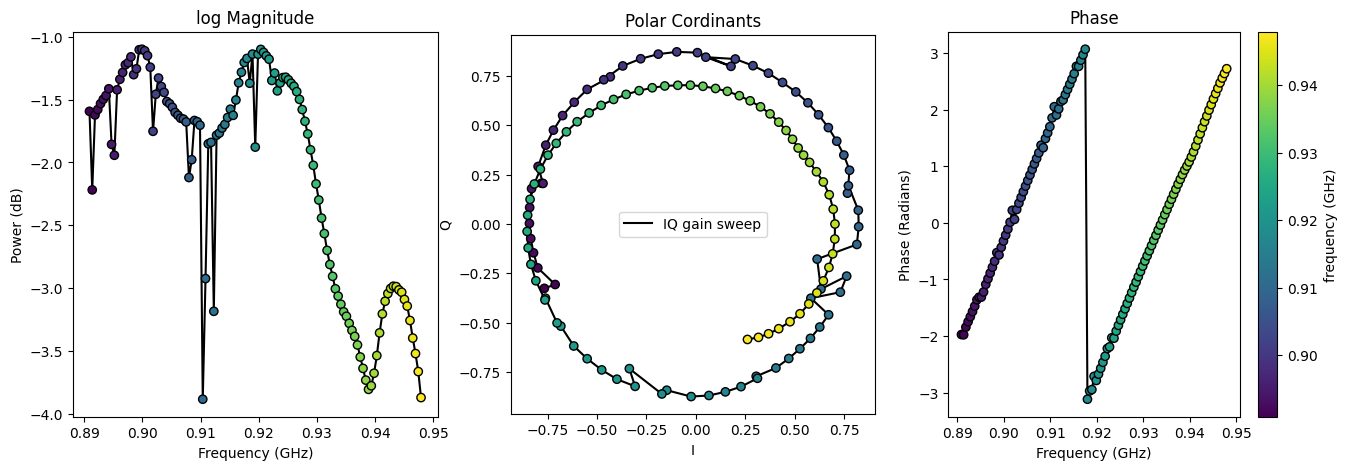

In [7]:
phase_gain = np.arctan2(np.real(z_iq_gain),np.imag(z_iq_gain))
fig, axs = plt.subplots(1, 3,figsize = (16,5))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
scat1 = ax1.scatter(f_iq_gain,20*np.log10(np.abs(z_iq_gain)),c = f_iq_gain,zorder = 2,edgecolors = 'k')
ax1.plot(f_iq_gain,20*np.log10(np.abs(z_iq_gain)),color = 'k',zorder = 1)
#fig.colorbar(scat1,label = "frequency (GHz)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Power (dB)")
ax1.set_title("log Magnitude")
scat2 = ax2.scatter(np.real(z_iq_gain),np.imag(z_iq_gain),c = f_iq_gain,zorder = 3,edgecolors = 'k')
ax2.plot(np.real(z_iq_gain),np.imag(z_iq_gain),color = 'k',zorder = 2,label = "IQ gain sweep")
ax2.legend()
ax2.set_title("Polar Cordinants")
ax2.set_aspect('equal')
ax2.set_xlabel("I")
ax2.set_ylabel("Q")
previous_xlim = ax2.get_xlim()
previous_ylim = ax2.get_ylim()
scat3 = ax3.scatter(f_iq_gain,np.arctan2(np.real(z_iq_gain),np.imag(z_iq_gain)),
                    c = f_iq_gain,zorder = 2,edgecolors = 'k')
ax3.plot(f_iq_gain,phase_gain,color = 'k',zorder = 1)
ax3.set_title("Phase")
ax3.set_xlabel("Frequency (GHz)")
ax3.set_ylabel("Phase (Radians)")
fig.colorbar(scat3,label = "frequency (GHz)")

Left shows a rough scan from 0.89 GHz to 0.95 GHz. There are some broad features in S21 and some dips where we have sampled some of the resonators on the network.

The middle shows this in IQ space, and we can see that cable delay causes a slow rotation around 0,0.

The right then plots the phase of this data, and we see a linear trend with frequency.

We want to fit the slope of this phase data to get the frequency-dependant phase correction term.

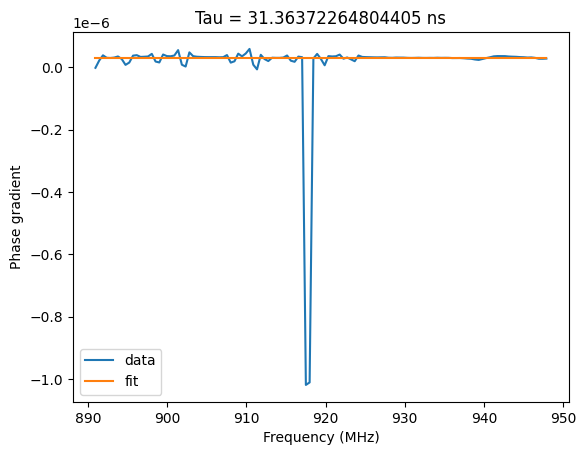

In [8]:
tau, phase_gradient = calibrate.fit_cable_delay_from_slope(f_iq_gain*10**9, phase_gain ,plot = True)

I find fitting the slope of the phase as it wraps in 2 pi tricky and very situational. So, instead, we can look at the slope (d$\theta$/df) of every adjacent set of frequency points and take the median value of those. This seems to be relatively robust

No lets see what happens if we take this cabel delay term out of the wide span data

We do this by applying a rotation 

z_corr = z*np.exp(2j*np.pi*tau*f)

(np.float64(-0.9371064731052944), np.float64(0.908252375466483))


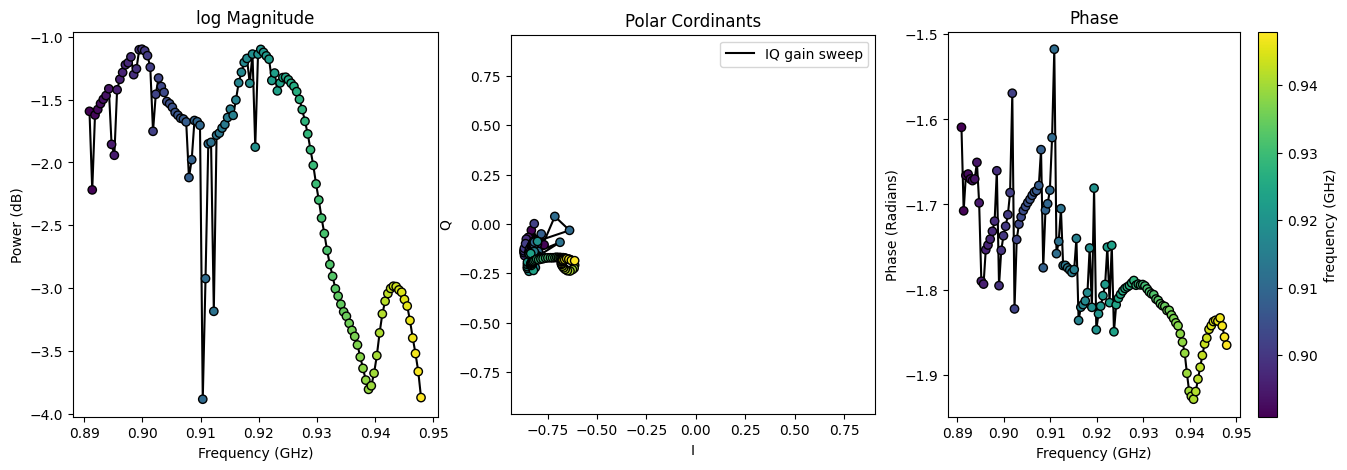

In [9]:
z_iq_gain_corr = z_iq_gain*np.exp(2j*np.pi*tau*f_iq_gain*10**9)
phase_gain = np.arctan2(np.real(z_iq_gain_corr),np.imag(z_iq_gain_corr))

fig, axs = plt.subplots(1, 3,figsize = (16,5))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
scat1 = ax1.scatter(f_iq_gain,20*np.log10(np.abs(z_iq_gain_corr)),c = f_iq_gain,zorder = 2,edgecolors = 'k')
ax1.plot(f_iq_gain,20*np.log10(np.abs(z_iq_gain_corr)),color = 'k',zorder = 1)
#fig.colorbar(scat1,label = "frequency (GHz)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Power (dB)")
ax1.set_title("log Magnitude")
scat2 = ax2.scatter(np.real(z_iq_gain_corr),np.imag(z_iq_gain_corr),c = f_iq_gain,zorder = 3,edgecolors = 'k')
ax2.plot(np.real(z_iq_gain_corr),np.imag(z_iq_gain_corr),color = 'k',zorder = 2,label = "IQ gain sweep")
ax2.legend()
ax2.set_title("Polar Cordinants")
ax2.set_aspect('equal')
ax2.set_xlabel("I")
ax2.set_ylabel("Q")
ax2.set_xlim(previous_xlim)
ax2.set_ylim(previous_ylim)
print(previous_xlim)
scat3 = ax3.scatter(f_iq_gain,np.arctan2(np.real(z_iq_gain_corr),np.imag(z_iq_gain_corr)),
                    c = f_iq_gain,zorder = 2,edgecolors = 'k')
ax3.plot(f_iq_gain,phase_gain,color = 'k',zorder = 1)
ax3.set_title("Phase")
ax3.set_xlabel("Frequency (GHz)")
ax3.set_ylabel("Phase (Radians)")
fig.colorbar(scat3,label = "frequency (GHz)")


We see now there is no reotation in polar cordinates and phase versus frequency is mostly flat

Now we can use this tau to also rotate the IQ calibration and stream data

Text(0, 0.5, 'Q')

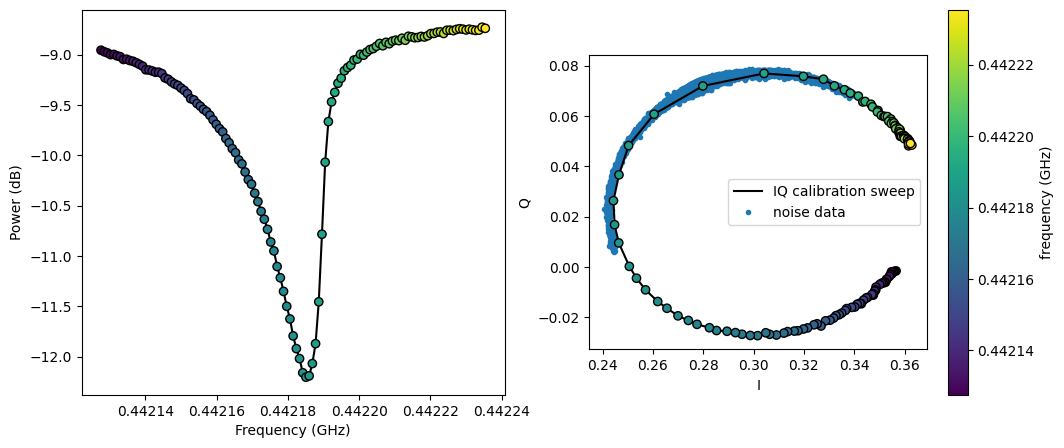

In [10]:
z_iq_corr = calibrate.remove_cable_delay(f_iq*10**9, z_iq, tau)
z_stream_corr = calibrate.remove_cable_delay(f_stream*10**9, z_stream, tau)
# replot
fig, axs = plt.subplots(1, 2,figsize = (12,5))
ax1 = axs[0]
#ax2 = axs[1]
ax3 = axs[1]
scat1 = ax1.scatter(f_iq,20*np.log10(np.abs(z_iq_corr)),c = f_iq,zorder = 2,edgecolors = 'k')
ax1.plot(f_iq,20*np.log10(np.abs(z_iq_corr)),color = 'k',zorder = 1)
#fig.colorbar(scat1,label = "frequency (GHz)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Power (dB)")

#scat2 = ax2.scatter(np.real(z_iq),np.imag(z_iq),c = f_iq,zorder = 3,edgecolors = 'k')
#ax2.plot(np.real(z_iq),np.imag(z_iq),color = 'k',zorder = 2,label = "IQ calibration sweep")
#ax2.plot(np.real(z_stream),np.imag(z_stream),'.',label = "noise data",zorder = 1)
#plt.legend()
#ax2.set_aspect('equal')
#fig.colorbar(scat2,label = "frequency (GHz)")
#ax2.set_xlabel("I")
#ax2.set_ylabel("Q")

scat3 = ax3.scatter(np.real(z_iq_corr),np.imag(z_iq_corr),c = f_iq,zorder = 3,edgecolors = 'k')
ax3.plot(np.real(z_iq_corr),np.imag(z_iq_corr),color = 'k',zorder = 2,label = "IQ calibration sweep")
ax3.plot(np.real(z_stream_corr),np.imag(z_stream_corr),'.',label = "noise data",zorder = 1)
plt.legend()
ax3.set_aspect('equal')
fig.colorbar(scat3,label = "frequency (GHz)")
ax3.set_xlabel("I")
ax3.set_ylabel("Q")


The effect is subtle we will try to examine it in detail better 

## Turning the streaming data into a frequency shift

If we look at the data we can can see that the streaming data is following the IQ calibration loop. This is becuase the resnance is moving and the streaming data is tracing out the resonant loop as the resonance moves. 

It is equavalent ot think of either the resonance moving or to think of the your probe tone for the streaming data as changing frequency 

As such we can determine the frequency of the resonator at each streaming data point by say what frequency point on the calibration loop is the each streamed point closest to.

The following is the process for do that systematically

now we want to move the iq loop to 0,0 and rotate it so that phase corresponse cleanly to a frequecy shift

First we fit a circle to find the center

Text(453.0220588235295, 0.5, 'Q')

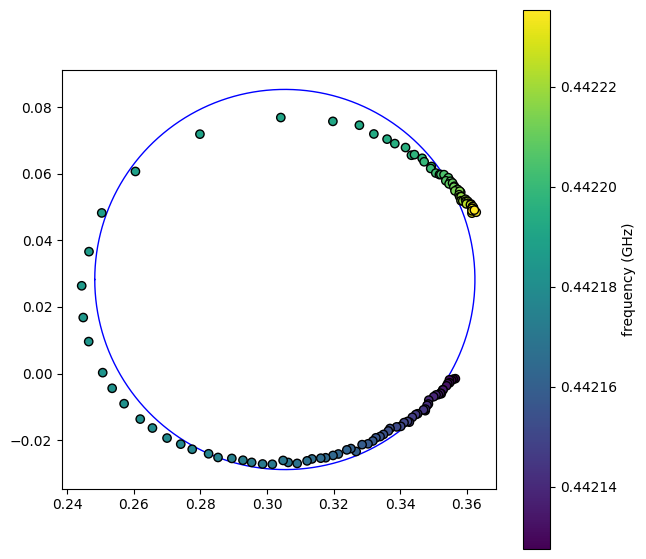

In [11]:
xc, yc, R, residu = calibrate.leastsq_circle(np.real(z_iq_corr), np.imag(z_iq_corr))

fig, ax1 = plt.subplots(1, 1,figsize = (7,7))
ax1.set_aspect('equal')
scat = ax1.scatter(np.real(z_iq_corr),np.imag(z_iq_corr),c = f_iq,zorder = 3,edgecolors = 'k')
calibrate.plot_data_circle(np.real(z_iq_corr),np.imag(z_iq_corr),xc, yc, R)
fig.colorbar(scat,label = "frequency (GHz)")
ax2.set_xlabel("I")
ax2.set_ylabel("Q")

Now we move it to 0,0

Text(0, 0.5, 'Q')

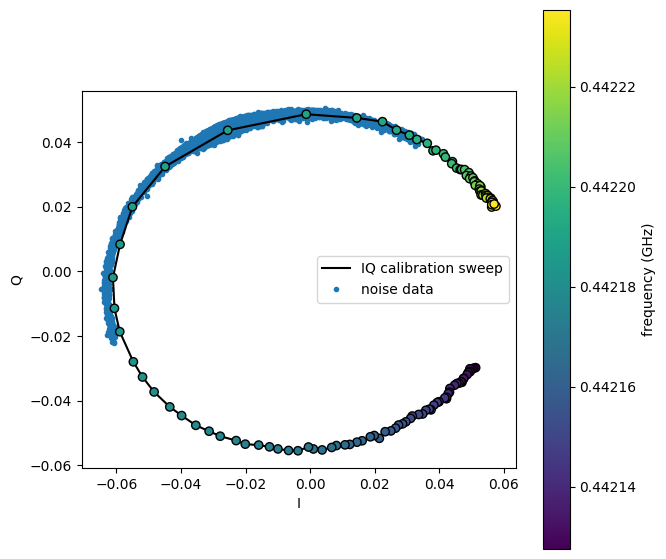

In [12]:
z_iq_corr_moved = z_iq_corr -xc -yc*1j
z_stream_corr_moved = z_stream_corr -xc -yc*1j

fig, ax1 = plt.subplots(1, 1,figsize = (7,7))
scat1 = ax1.scatter(np.real(z_iq_corr_moved),np.imag(z_iq_corr_moved),c = f_iq,zorder = 3,edgecolors = 'k')
ax1.plot(np.real(z_iq_corr_moved),np.imag(z_iq_corr_moved),color = 'k',zorder = 2,label = "IQ calibration sweep")
ax1.plot(np.real(z_stream_corr_moved),np.imag(z_stream_corr_moved),'.',label = "noise data",zorder = 1)
plt.legend()
ax1.set_aspect('equal')
fig.colorbar(scat1,label = "frequency (GHz)")
ax1.set_xlabel("I")
ax1.set_ylabel("Q")

Now we want to rotate the the data

There are to choices for how to rotate the noise data. 

1 rotate streaming data to be at 0,1 in IQ plane. 
This maps frequency noise to real part and dissipation noise
to the imaginary part (assumes noise ball is small)
This is useful in becuase often you can assume that noise parrallel (in ther frequency direction) to the IQ loop is detector noise and the noise perpendicular to the IQ loop is amplifier/readout since the amplfier does not care about the freuqency shift of the resonator. 

2 rotates data such that the furthest off res points
in the IQ loop will be places at +/-pi. This makes interpolation 
from phase to frequency not have a jump as phase goes from +pi to -pi
This is good when you havce large deviations with lab measurements like the above data and can no longer assume the noise ball is small



Text(0, 0.5, 'Q')

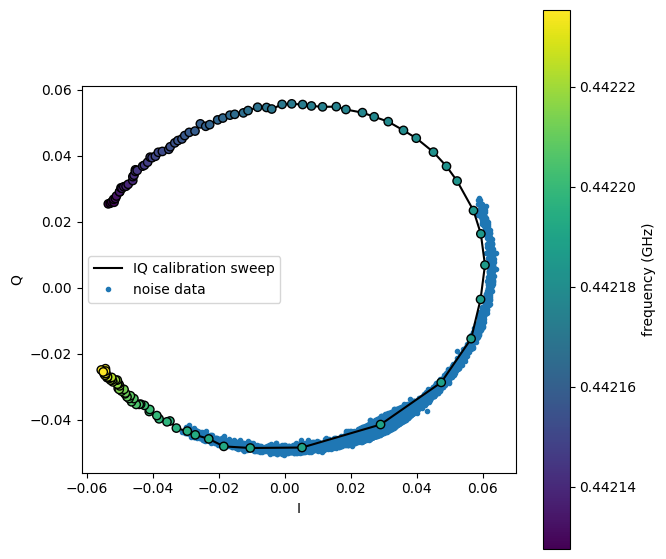

In [13]:
rotation_mode = 2
if rotation_mode == 2: # if you have data that covers a large part of the iq loop
    med_phase = np.arctan2(np.imag(z_iq_corr_moved[0]+z_iq_corr_moved[-1]),
                                    np.real(z_iq_corr_moved[0]+z_iq_corr_moved[-1])) + np.pi
    extrap = "min_max"
else:
    med_phase = np.median(np.arctan2(np.real(z_stream_corr_moved),np.imag(z_stream_corr_moved)))
    extrap = "extrapolate"
    
z_iq_corr_moved_rotated = z_iq_corr_moved*np.exp(-1j*med_phase)
z_stream_corr_moved_rotated = z_stream_corr_moved*np.exp(-1j*med_phase)

fig, ax1 = plt.subplots(1, 1,figsize = (7,7))
scat1 = ax1.scatter(np.real(z_iq_corr_moved_rotated),np.imag(z_iq_corr_moved_rotated),c = f_iq,zorder = 3,edgecolors = 'k')
ax1.plot(np.real(z_iq_corr_moved_rotated),np.imag(z_iq_corr_moved_rotated),color = 'k',zorder = 2,label = "IQ calibration sweep")
ax1.plot(np.real(z_stream_corr_moved_rotated),np.imag(z_stream_corr_moved_rotated),'.',label = "noise data",zorder = 1)
plt.legend()
ax1.set_aspect('equal')
fig.colorbar(scat1,label = "frequency (GHz)")
ax1.set_xlabel("I")
ax1.set_ylabel("Q")

Now we want to interpolate using the IQ sweep to turn the phase of the streaming data into a frequency shift

Text(0, 0.5, 'Frequency')

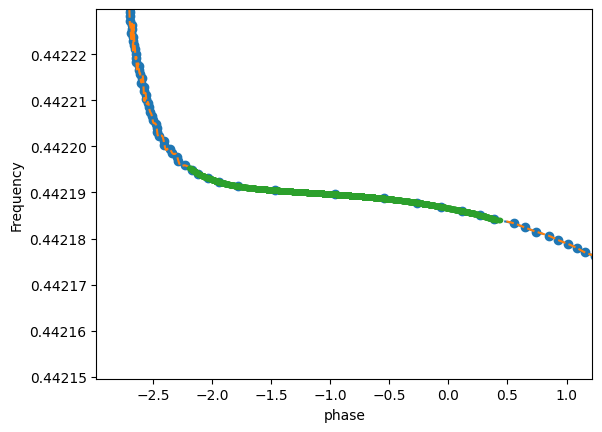

In [14]:
phase_stream = np.arctan2(np.imag(z_stream_corr_moved_rotated),np.real(z_stream_corr_moved_rotated))
phase_IQ = np.arctan2(np.imag(z_iq_corr_moved_rotated),np.real(z_iq_corr_moved_rotated))
stream_df_over_f,interp_function = calibrate.interp_phase_to_df_over_f(phase_IQ,
                                                phase_stream,
                                                f_iq,
                                                extrap = extrap)


phase_small = np.linspace(np.min(phase_IQ),np.max(phase_IQ),1000)
freqs_stream = interp_function(phase_stream)

plt.plot(phase_IQ,f_iq,'o--')
plt.plot(phase_small,interp_function(phase_small),'--')
plt.plot(phase_stream,freqs_stream,'.')
ylim_upper = np.max(freqs_stream)+(np.max(freqs_stream)-np.min(freqs_stream))*3
if ylim_upper>np.max(f_iq):
    ylim_upper = np.max(f_iq)
ylim_lower = np.min(freqs_stream)-(np.max(freqs_stream)-np.min(freqs_stream))*3
if ylim_lower<np.min(f_iq):
    ylim_lower = np.min(f_iq)
plt.ylim(ylim_lower,ylim_upper)
plt.xlim(np.min(phase_stream)-np.pi/4,np.max(phase_stream)+np.pi/4)
plt.xlabel("phase")
plt.ylabel("Frequency")

this has given us a way to turn the data from IQ into a frequency. Really what you want is to look at df/f (f-f0)/f0 as this is what is proportional to power and not also proportional to the resonator frequency.

Text(0, 0.5, 'df/f')

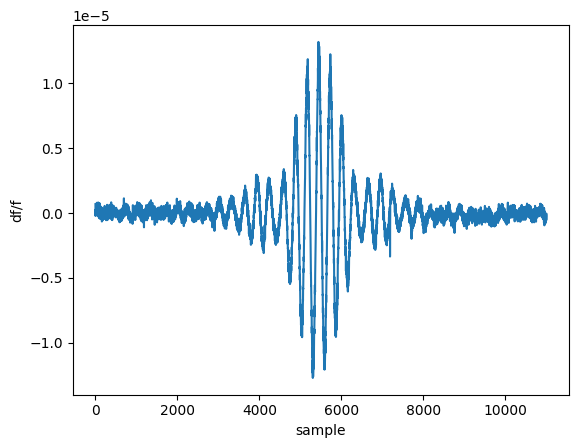

In [19]:
df_over_f = (freqs_stream-np.median(freqs_stream))/np.median(freqs_stream)
plt.plot(df_over_f[34000:45000])
plt.xlabel("sample")
plt.ylabel("df/f")

Examining the plot you can see an interferogram showing that this was actually some Fourier transform spectometer data